In [370]:
%matplotlib notebook
import math
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sci
from scipy.optimize import curve_fit
from matplotlib import rc
from IPython.display import display, Math, Markdown
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)
path = "C:/Users/Thomas/Laboratorio_Intermedio/Torsional Oscillator/Data/"
path_ = "C:/Users/Thomas/Laboratorio_Intermedio/Torsional Oscillator/Curves/"

> ## Bitácora - Experimento del Oscilador Torsional

**Hecho por:** Simón Felipe Jimenez Botero & Thomas Andrade Hernández.

---

En el presente documento se encuentran desglozados los resultados de las mediciones asociadas al montaje experimental del Oscilador Torsional. A lo largo de este código se podrán observar los resultados de cada medición, gráficas e información relacionada a cada una de las regresiones que se realicen, sumado a una breve explicación previa acerca de aquello que estamos haciendo, cómo lo estamos haciendo y alguna que otra cosa a tener presente para su replicación.

---

In [371]:
def linear(X, a, b):
    return a*X + b


def Error(valor_principal, incertidumbre):
    # Determinar cuántas cifras significativas tiene la incertidumbre
    if incertidumbre == 0:
        return valor_principal, incertidumbre  # Evita la división por cero
    
    cifras_significativas = -int(math.floor(math.log10(incertidumbre)))
    
    # Redondear el valor principal y la incertidumbre a esas cifras significativas
    valor_redondeado = round(valor_principal, cifras_significativas)
    incertidumbre_redondeada = round(incertidumbre, cifras_significativas)
    
    return valor_redondeado, incertidumbre_redondeada

def Computation_Error(expression, symbols, parameters):
    error_2 = 0.
    ward = int((len(symbols)/2))
    func_value = sym.lambdify(symbols[0:ward], expression)
    value = func_value(*parameters[0:ward])

    for i in range(0, len(symbols[0:ward])):
        unc_ward = ward + i
        error_2 += sym.diff(expression, symbols[i])**2 * (symbols[unc_ward])**2

    func_error_2 = sym.lambdify(symbols, error_2)
    value_error_2 = func_error_2(*parameters)
    
    error = np.sqrt(value_error_2)
    
    value, error = Error(value, error)
    
    return value, error


---

> **Primera Actividad: Calibración del Rotor.**

Para poder llevar a cabo todos los cálculos del experimento, es necesario establecer un valor para el ángulo inicial $\theta$ el cual genere una señal de voltaje pico a pico $V_{pp}$ en el que la magnitud sea nula. Para esto, se registran los datos del voltaje pico a pico en función de la amplitud del ángulo inicial:

In [424]:
rotor_calib = "Rotor_Calibration.xlsx"
rotor_data = pd.read_excel(path + rotor_calib)

In [434]:
angle = rotor_data["Angle [rad]"].to_numpy()
allangle = np.linspace(angle[0], angle[-1], 100)
voltage = rotor_data["Vpp [mV]"].to_numpy()*1/1000

voltage_coeff, voltage_cov = curve_fit(linear, angle, voltage)
voltage_unc = np.sqrt(np.diag(voltage_cov))
voltage_residues = voltage - linear(angle, *voltage_coeff)

<IPython.core.display.Javascript object>


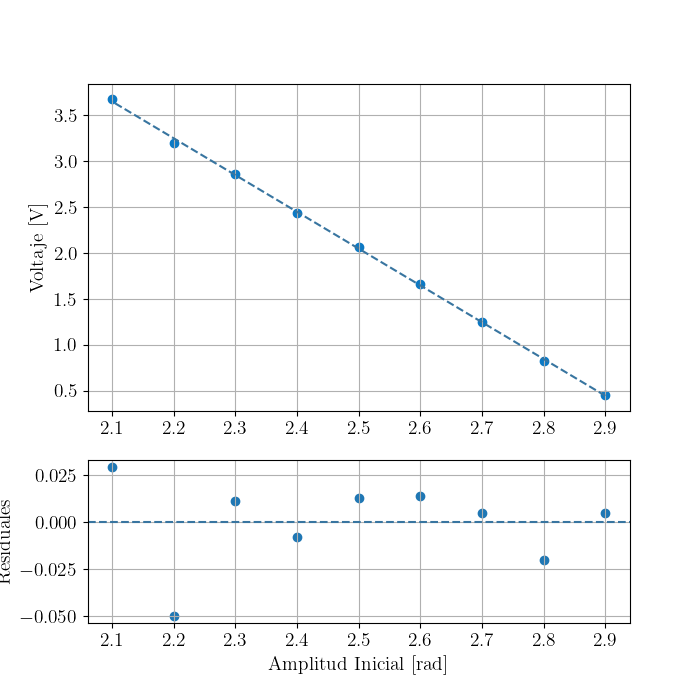

In [435]:
figure, axis = plt.subplots(2, 1, figsize = (7, 7), gridspec_kw={'height_ratios': [2, 1]})
axis[0].scatter(angle, voltage, color = "#0C79C4")
axis[0].plot(allangle, linear(allangle, *voltage_coeff), color = "#3875A0", linestyle = "--")
axis[0].set_ylabel("Voltaje [V]")
axis[0].grid(True)


axis[1].scatter(angle, voltage_residues)
axis[1].set_ylabel("Residuales")
axis[1].axhline(0, color = "#3875A0", linestyle = "--")
axis[1].set_xlabel("Amplitud Inicial [rad]")
axis[1].grid(True)

plt.savefig("Calibration.pdf")

In [436]:
b, m, uncb, uncm = sym.symbols("b, m, sigma_b, sigma_m", real = True)
angle_zero_sym = b, m, uncb, uncm
angle_zero_param = (voltage_coeff[1], voltage_coeff[0], voltage_unc[1], voltage_unc[0])
angle_zero_exp = -b/m

angle, unc_angle = Computation_Error(angle_zero_exp, angle_zero_sym, angle_zero_param)

In [437]:
display(Markdown(r"El valor del ángulo asociado al cero de voltage para el rotor es de ${} \pm {}$ radianes.".format(angle, unc_angle)))

El valor del ángulo asociado al cero de voltage para el rotor es de $3.01 \pm 0.03$ radianes.

Ya con este valor en mente, todas las actividades que vienen a continuación se deben llevar a cabo para esta configuración inicial.

---

> **Segunda Actividad: Aplicación del Torque Mecánico.**

Para llevar a cabo esta actividad, se hizo uso del sistema de poleas que está integrado en los laterales del montaje. Una vez conectado el sistema de manera adecuada **(considerando el sentido en el que se dirigen los torques de cada polea para evitar que se cancele el uno con el otro)**. Los pasos a seguir son:

**1)** Tras haber conectado de manera adecuada cada masa al sistema, medir la nueva posición de equilibrio para el sistema una vez se establecen las bases para las masas. Posterior a esto, determine el **radio del eje del rotor (?)** sobre el cual se encuentra enganchado el hilo. El valor en cuestión debe estar entre $12.7$ mm y $25.4$ mm. ¿Por qué se oscila entre estos valores?

- **Comentario:**

**2)** Comience por colocar ahora, en las bases laterales, masas de $500$ gramos en cada una. Posteriormente, **incremente de manera coherente (?)** hasta llegar a 900 gramos, anotando en cada caso el nuevo punto de equilibrio.

- **Comentario:**

**3)** Repita este procedimiento para el caso en el que se invierte el sentido en que se amarraron los hilos de las poleas, para así obtener un barrido en las zonas negativas.


- **Comentario:**

**4)** Graficar el toque generado por las masas $\tau$ con respecto al cambio en el ángulo de equilibrio $\Delta\theta$. Partiendo de esto, determinar la constante de torsión $\kappa$, teniendo en cuenta las siguientes consideraciones teóricas:

Notar que el torque generado por las masas en las poleas, si es aplicado de forma correcta, tiene como magnitud:

$$\tau = 2rmg$$

donde $r$ es el radio de las poleas y el $2$ surge de la suma de los torques de ambas poleas, las cuales tendrán siempre los mismos valores de masa pendiendo de las mismas. También, el torque general del sistema se puede obtener como:

$$\tau = -\kappa\theta$$

de forma análoga con el sistema masa resorte. Así, igualando ambas expresiones es posible determinar que:

$$2rmg = -\kappa\theta$$

que a nivel práctico es realizar una gráfica de la forma de las masas en cada soporte $m$ contra el cambio en el ángulo de equilibrio $\Delta\theta$. El cálculo del valor es el siguiente:

In [377]:
mechanic_torq = "Mechanic_Torque.xlsx"
mechanic_data = pd.read_excel(path + mechanic_torq)
mechanic_data

,Angle (+) [rad],Mass (+) [g],Angle (-) [rad],Mass (-) [g]
0,2.80,99.4,3.20,-99.4
1,2.60,199.5,3.36,-199.5
2,2.42,299.7,3.56,-299.7
3,2.28,399.2,3.70,-399.2
4,2.16,499.3,3.80,-499.3
5,2.06,598.8,3.94,-598.8
6,1.98,699.6,4.04,-699.6
7,1.90,799.1,4.10,-799.1


In [378]:
plus_torque = mechanic_data["Mass (+) [g]"].to_numpy()*(1/1000)
plus_angle = mechanic_data["Angle (+) [rad]"].to_numpy()
minus_torque = mechanic_data["Mass (-) [g]"].to_numpy()*(1/1000)
minus_angle = mechanic_data["Angle (-) [rad]"].to_numpy()

total_torque = np.append(minus_torque[::-1], plus_torque)
total_angle = np.append(minus_angle[::-1], plus_angle)

torque_coeff, torque_cov = curve_fit(linear, total_angle, total_torque)
torque_unc = np.sqrt(np.diag(torque_cov))
torque_residues = total_torque - linear(total_angle, *torque_coeff)

<IPython.core.display.Javascript object>


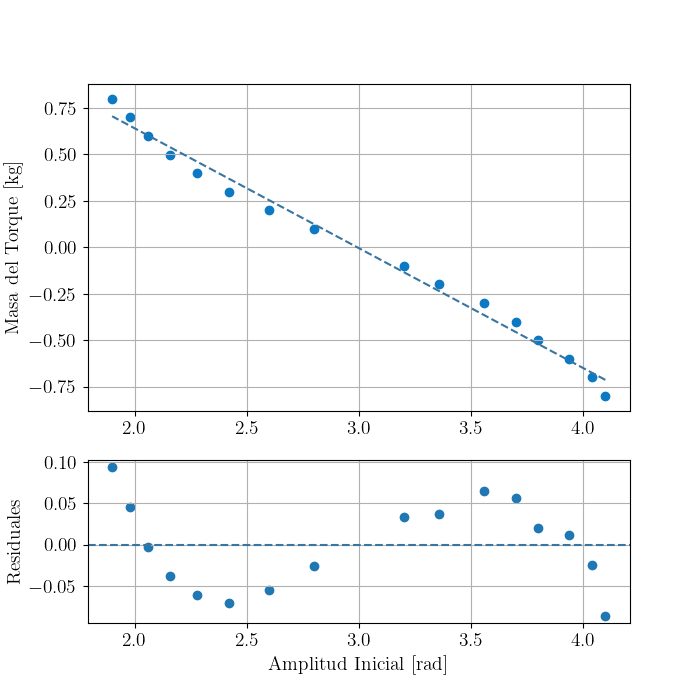

In [379]:
figure, axis = plt.subplots(2, 1, figsize = (7, 7), gridspec_kw={'height_ratios': [2, 1]})
axis[0].scatter(total_angle, total_torque, color = "#0C79C4")
axis[0].plot(total_angle, linear(total_angle, *torque_coeff), color = "#3875A0", linestyle = "--")
axis[0].set_ylabel("Masa del Torque [kg]")
axis[0].grid(True)


axis[1].scatter(total_angle, torque_residues)
axis[1].set_ylabel("Residuales")
axis[1].set_xlabel("Amplitud Inicial [rad]")
axis[1].axhline(0, color = "#3875A0", linestyle = "--")
axis[1].grid(True)

plt.savefig("Torsion_1.pdf")

In [380]:
r, m, uncr, uncm = sym.symbols("r, m, sigma_r, sigma_m", real = True)

g = 9.81 # m/s^2

torsion1_sym = r, m, uncr, uncm
torsion1_param = (0.0127, torque_coeff[0], 0.0001, torque_unc[0])
torsion1_exp = -2*r*g*m

torsion1, torsion1_unc = Computation_Error(torsion1_exp, torsion1_sym, torsion1_param)
torsion1, torsion1_unc

(0.161, 0.005)

In [381]:
theoric_torsion_constant = 0.058 # Nm/rad
percentage = round(((theoric_torsion_constant - torsion1)/theoric_torsion_constant) * 100, 1)
display(Markdown(r"El valor de la constante de torsión asociada al montaje es de $\kappa_1 = {} \pm {}$ Nm/rad, la cual difiere un ${}$% del valor teórico.".format(torsion1, torsion1_unc, percentage)))

El valor de la constante de torsión asociada al montaje es de $\kappa_1 = 0.161 \pm 0.005$ Nm/rad, la cual difiere un $-177.6$% del valor teórico.

Como se logra apreciar, este valor obtenido es (DESCRIPCIÓN GENERAL).

---

> **Tercera Actividad: Momento Inercial.**

Otra manera de determinar la constante de torsión del experimento, así como el momento de inercia inicial del sistema (sin la inclusión de las masas), se consigue mediante la expresión:

$$\left(\frac{T}{2\pi}\right)^{2} = \frac{1}{\kappa} \left(I_{0} + n\Delta{I}\right)$$

$$\left(\frac{T}{2\pi}\right)^{2} = \frac{I_{0}}{\kappa} + \frac{n\Delta{I}}{\kappa}$$


donde el $\Delta{I}$ representa el momento de inercia asociado a una sola de los cuadrantes:

$$\Delta{I} = \frac{M(R_{2}^{2} + R_{1}^{2})}{2}$$

y $\kappa$, la constante de torsión del sistema. El código que realiza estos cálculos es:

In [382]:
inertia = "Inertia.xlsx"
inertia_data = pd.read_excel(path + inertia)

Conocemos los valores de las masas, sus radios y sus incertidumbres asociadas:

In [383]:
M_ = 0.212 # Kilogramos
R1 = 0.0225 # Metros
R2 = 0.047 # Metros

In [384]:
number_masses = inertia_data["Masses [n]"].to_numpy()
period = inertia_data["Period [s]"].to_numpy()
period_scaled = period**2

inertia_coeff, inertia_cov = curve_fit(linear, number_masses, period_scaled)
inertia_unc = np.sqrt(np.diag(inertia_cov))
inertia_residues = period_scaled - linear(number_masses, *inertia_coeff)

<IPython.core.display.Javascript object>


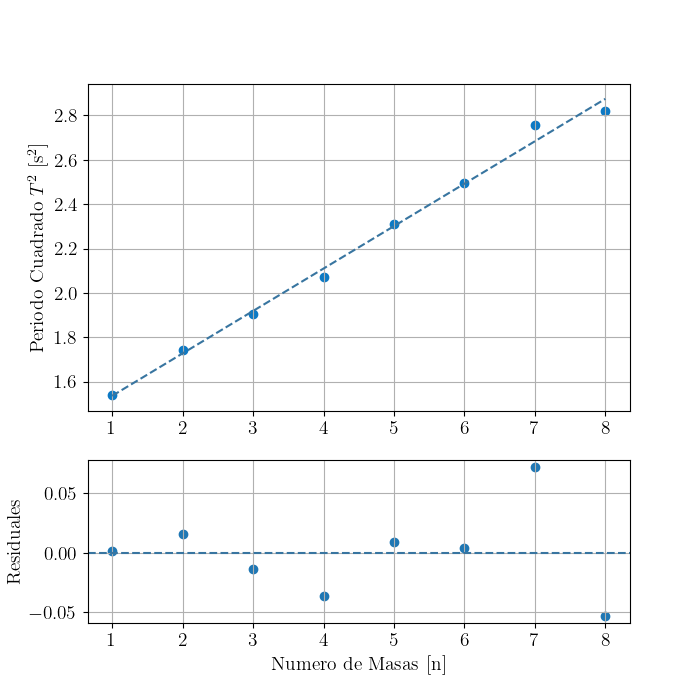

In [385]:
figure, axis = plt.subplots(2, 1, figsize = (7, 7), gridspec_kw={'height_ratios': [2, 1]})
axis[0].scatter(number_masses, period_scaled, color = "#0C79C4")
axis[0].plot(number_masses, linear(number_masses, *inertia_coeff), color = "#3875A0", linestyle = "--")
axis[0].set_ylabel(r"Periodo Cuadrado $T^{2}$ [s$^{2}$]")
axis[0].grid(True)


axis[1].scatter(number_masses, inertia_residues)
axis[1].set_ylabel("Residuales")
axis[1].axhline(0, color = "#3875A0", linestyle = "--")
axis[1].set_xlabel("Numero de Masas [n]")
axis[1].grid(True)

plt.savefig("Torsion_2.pdf")

In [386]:
M, R_1, R_2, unc_M, unc_R1, unc_R2 = sym.symbols("M, R_1, R_2, unc_M, unc_R1, unc_R2", real = True)

dI_sym = M, R_1, R_2, unc_M, unc_R1, unc_R2
dI_exp = (M*(R_1**2 + R_2**2))/2
dI_param = (0.212, 0.0225, 0.047, 0.001, 0.0001, 0.0001)

dI, dI_unc = Computation_Error(dI_exp, dI_sym, dI_param)

In [387]:
m, dI_, uncm, dI_unc_ = sym.symbols("m, dI, sigma_m, sigma_dI", real = True)
torsion2_sym = m, dI_, uncm, dI_unc_
torsion2_param = (inertia_coeff[0], dI, inertia_unc[0], dI_unc)
torsion2_exp = (4*sym.pi**2)*dI_/m

torsion2, torsion2_unc = Computation_Error(torsion2_exp, torsion2_sym, torsion2_param)

In [388]:
inertia_percentage = round(((theoric_torsion_constant - torsion2)/theoric_torsion_constant) * 100, 1)
display(Markdown(r"El valor de la constante de torsión asociada al montaje es de $\kappa_2 = {} \pm {}$ Nm/rad (para el segundo método), la cual difiere un ${}$% del valor teórico.".format(torsion2, torsion2_unc, inertia_percentage)))

El valor de la constante de torsión asociada al montaje es de $\kappa_2 = 0.059 \pm 0.002$ Nm/rad (para el segundo método), la cual difiere un $-1.7$% del valor teórico.

In [389]:
display(Markdown(r"Los valores encontrados para la constante de torsión son, para el primer método, $\kappa_1 = {} \pm {}$ Nm/rad y para el segundo método $\kappa_2 = {} \pm {}$ Nm/rad.".format(torsion1, torsion1_unc, torsion2, torsion2_unc, inertia_percentage)))

Los valores encontrados para la constante de torsión son, para el primer método, $\kappa_1 = 0.161 \pm 0.005$ Nm/rad y para el segundo método $\kappa_2 = 0.059 \pm 0.002$ Nm/rad.

> **Cuarta Actividad: Torque Magnético.**

En este apartado nos centramos en estudiar el comportamiento del oscilador torsional una vez las bobinas de Helmholtz se encuentran accionadas. Considerando el flujo de una corriente DC a lo largo de las bobinas, el campo magnético generado es uniforme, lo que hace que los imanes "conectados" al alambre del oscilador torsional se orienten en función de la dirección de este campo. Se llevará a cabo el siguiente procedimiento:

**1)** Se registrará una muestra de mínimo 20 datos en los que hayan valores de corriente positiva y negativa. Así, se debe construir una gráfica de corriente $I$ en función del cambio de la posición de equilibrio $\Delta\theta$.

**2)** A partir de la gráfica, realizar una regresión lineal en las regiones que así lo permita, además de hablar al respecto de este comportamiento.

- **Comentario:**

**3)** Determinar el valor del momento magnético del imán central partiendo de la relación:

$$\theta = \mu\frac{k}{\kappa}I$$

donde $\mu$ es el momento magnético, $k = 3234 \times 10^{-6}$ T/A la constante de Helmholtz de las bobinas y $\kappa$ la constante de torsión calculada. 

In [390]:
magnetic_torq = "Magnetic_Torque.xlsx"
magnetic_data = pd.read_excel(path + magnetic_torq)
magnetic_data

,Current (+) [A],Angle (+) [rad],Current (-) [A],Angle (-) [rad]
0,0.00,3.00,-2.00,3.86
1,0.25,2.84,-1.75,3.82
2,0.50,2.68,-1.50,3.76
3,0.75,2.54,-1.25,3.68
4,1.00,2.44,-1.00,3.58
5,1.25,2.34,-0.75,3.46
6,1.50,2.26,-0.50,3.32
7,1.75,2.18,-0.25,3.18
8,2.00,2.12,0.00,3.00


In [433]:
magnet_currentplus = magnetic_data["Current (+) [A]"]
magnet_angleplus = magnetic_data["Angle (+) [rad]"]
magnet_currentminus = magnetic_data["Current (-) [A]"]
magnet_angleminus = magnetic_data["Angle (-) [rad]"]

magnet_Tcurrent = np.append(magnet_currentminus[::-1], magnet_currentplus)
magnet_Tangle = np.append(magnet_angleminus[::-1], magnet_angleplus)

magnet_coeff, magnet_cov = curve_fit(linear, magnet_Tcurrent, magnet_Tangle)
magnet_unc = np.sqrt(np.diag(magnet_cov))
magnet_residues = magnet_Tangle - linear(magnet_Tcurrent, *magnet_coeff)

<IPython.core.display.Javascript object>


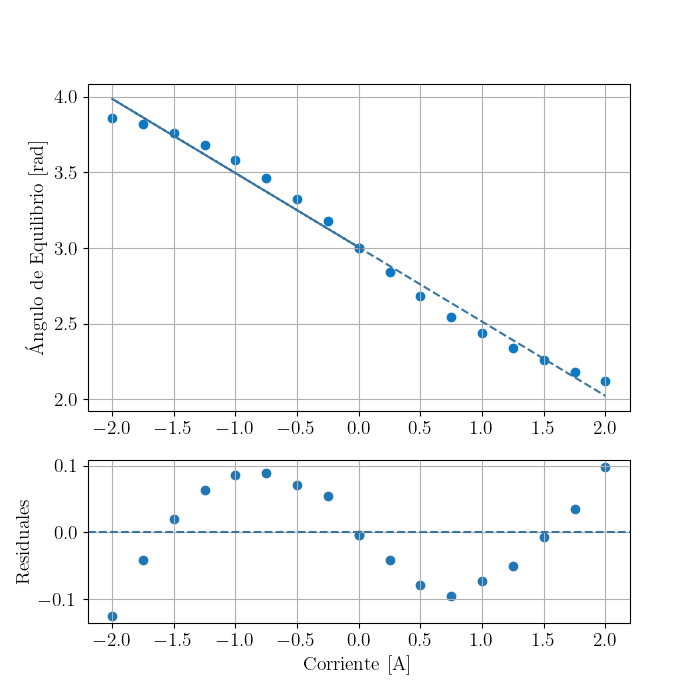

In [431]:
figure, axis = plt.subplots(2, 1, figsize = (7, 7), gridspec_kw={'height_ratios': [2, 1]})
axis[0].scatter(magnet_Tcurrent, magnet_Tangle, color = "#0C79C4")
axis[0].plot(magnet_Tcurrent, linear(magnet_Tcurrent, *magnet_coeff), color = "#3875A0", linestyle = "--")
axis[0].set_ylabel("Ángulo de Equilibrio [rad]")
axis[0].grid(True)


axis[1].scatter(magnet_Tcurrent, magnet_residues)
axis[1].axhline(0, color = "#3875A0", linestyle = "--")
axis[1].set_ylabel("Residuales")
axis[1].set_xlabel("Corriente [A]")
axis[1].grid(True)

plt.savefig("Magnetic_Torque.pdf")

In [393]:
M, k, kappa, unc_M, unc_k, unc_kappa = sym.symbols("M, k, kappa, unc_M, unc_k, unc_kappa", real = True)

mu_sym = M, k, kappa, unc_M, unc_k, unc_kappa
mu_exp = M*kappa/k
mu_param = (magnet_coeff[0], 3234*(10**(-6)), torsion2, magnet_unc[0], 0., torsion2_unc)
mu, mu_unc = Computation_Error(mu_exp, mu_sym, mu_param)
mu, mu_unc

(-9.0, 0.4)

> **Quinta Actividad: Torque Magnético.**

En este apartado nos centramos en estudiar el comportamiento del oscilador torsional una vez se aplica un amortiguamiento mediante los imanes anexados en la zona lateral del montaje. Se busca determinar información del factor de calidad de éstas oscilaciones. La expresión base para la obtención de las regresiones es:

$$\theta(t) = Ae^{-bt/2}\cos(ct + d)$$

donde sabemos que $A = V_{0}$, $b = \gamma$, $c = \omega$ y $d = \delta$ (un desfase).Recordar que el factor de calidad será:

$$Q = \frac{\sqrt{\omega^{2} + (\gamma/2)^{2}}}{\gamma}$$

El proceso realizado es el siguiente:

In [394]:
def Dumping(X, a, b, c, d):
    return a*(np.e)**(b*X/2)*np.cos(c*X + d)

omega, gamma, unc_omega, unc_gamma = sym.symbols("omega, gamma, unc_omega, unc_gamma", real = True)

Q_sym = omega, gamma, unc_omega, unc_gamma
Q_exp = sym.sqrt(omega**2 + (gamma/2)**2)/gamma

In [395]:
first_data = "First Measure.csv"
first_pack = pd.read_csv(path_ + first_data)

In [396]:
bins = 30
ficsit = 30
fTime = first_pack["Time [s]"].to_numpy()[bins:-300]/10
_fTime_ = np.linspace(fTime[0], fTime[-1], 1000)
fVoltage = first_pack["Voltage [V]"].to_numpy()[bins:-300]

fTime_coeff, fTime_cov = curve_fit(Dumping, fTime[ficsit:], fVoltage[ficsit:])
fTime_unc = np.sqrt(np.diag(fTime_cov))
fTime_residues = fVoltage - Dumping(fTime, *fTime_coeff)

In [397]:
Q1_param = (fTime_coeff[2], np.abs(fTime_coeff[1]), fTime_unc[2], fTime_unc[1])
Q1, Q1_unc = Computation_Error(Q_exp, Q_sym, Q1_param)
Q1, Q1_unc

(4.59, 0.01)

In [398]:
display(Markdown(r"El factor de calidad de esta oscilación es de ${} \pm {}$.".format(Q1, Q1_unc)))

El factor de calidad de esta oscilación es de $4.59 \pm 0.01$.

In [399]:
second_data = "Second Measure.csv"
second_pack = pd.read_csv(path_ + second_data)

In [400]:
sbins = 130
sficsit = 40
sTime = second_pack["Time [s]"].to_numpy()[sbins:-sbins]/10
_sTime_ = np.linspace(sTime[0], sTime[-1], 1000)
sVoltage = second_pack["Voltage [V]"].to_numpy()[sbins:-sbins]

sTime_coeff, sTime_cov = curve_fit(Dumping, sTime[sficsit:], sVoltage[sficsit:])
sTime_unc = np.sqrt(np.diag(sTime_cov))
sTime_residues = sVoltage - Dumping(sTime, *sTime_coeff)

In [401]:
Q2_param = (sTime_coeff[2], np.abs(sTime_coeff[1]), sTime_unc[2], sTime_unc[1])
Q2, Q2_unc = Computation_Error(Q_exp, Q_sym, Q2_param)
Q2, Q2_unc

(8.15, 0.02)

In [402]:
display(Markdown(r"El factor de calidad de esta oscilación es de ${} \pm {}$.".format(Q2, Q2_unc)))

El factor de calidad de esta oscilación es de $8.15 \pm 0.02$.

In [403]:
third_data = "Third Measure.csv"
third_pack = pd.read_csv(path_ + third_data)

In [404]:
tbins = 130
tTime = third_pack["Time [s]"].to_numpy()[tbins + 80:-tbins]/10
_tTime_ = np.linspace(tTime[0], tTime[-1], 1000)
tVoltage = third_pack["Voltage [V]"].to_numpy()[tbins + 80:-tbins]

tTime_coeff, tTime_cov = curve_fit(Dumping, tTime, tVoltage)
tTime_unc = np.sqrt(np.diag(tTime_cov))
tTime_residues = tVoltage - Dumping(tTime, *tTime_coeff)

In [405]:
Q3_param = (tTime_coeff[2], np.abs(tTime_coeff[1]), tTime_unc[2], tTime_unc[1])
Q3, Q3_unc = Computation_Error(Q_exp, Q_sym, Q3_param)
Q3, Q3_unc

(13.12, 0.05)

In [406]:
display(Markdown(r"El factor de calidad de esta oscilación es de ${} \pm {}$.".format(Q3, Q3_unc)))

El factor de calidad de esta oscilación es de $13.12 \pm 0.05$.

<IPython.core.display.Javascript object>


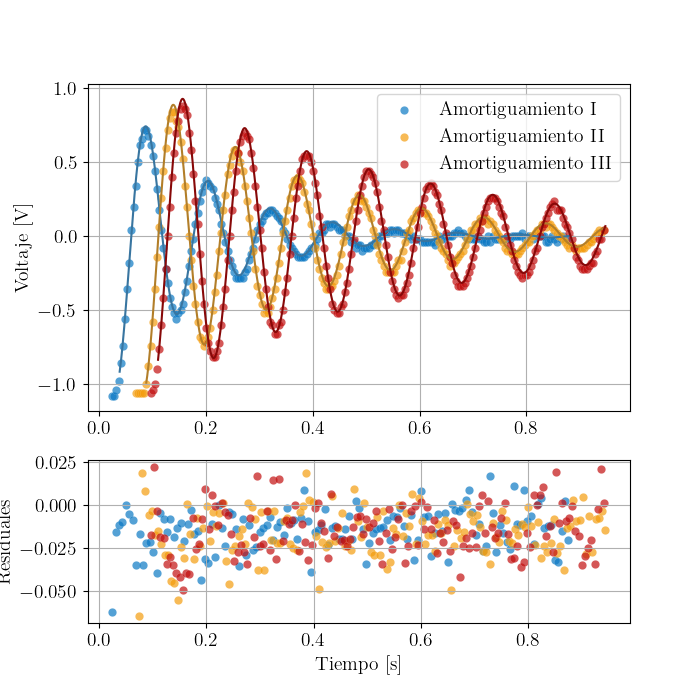

In [407]:
figure, axis = plt.subplots(2, 1, figsize = (7, 7), gridspec_kw={'height_ratios': [2, 1]})

axis[0].scatter(fTime[ficsit:][::10], fVoltage[ficsit:][::10], color = "#0C79C4", edgecolors = "white", linewidths = 0.1, alpha = 0.7, label = "Amortiguamiento I")
axis[0].plot(_fTime_[ficsit:], Dumping(_fTime_, *fTime_coeff)[ficsit:], color = "#3875A0")

axis[1].scatter(fTime[ficsit:][::16], fTime_residues[ficsit:][::16], color = "#0C79C4", edgecolors = "white", linewidths = 0.1, alpha = 0.7)


axis[0].scatter(sTime[sficsit:][::10], sVoltage[sficsit:][::10], color = "#F49D0E", edgecolors = "white", linewidths = 0.1, alpha = 0.7, label = "Amortiguamiento II")
axis[0].plot(_sTime_[sficsit:], Dumping(_sTime_, *sTime_coeff)[sficsit:], color = "#B27E29")

axis[1].scatter(sTime[sficsit + 15:][::15], sTime_residues[sficsit + 15:][::15], color = "#F49D0E", edgecolors = "white", linewidths = 0.1, alpha = 0.7)

axis[0].scatter(tTime[ficsit:][::10], tVoltage[ficsit:][::10], color = "#C21010", edgecolors = "white", linewidths = 0.1, alpha = 0.7, label = "Amortiguamiento III")
axis[0].plot(_tTime_[ficsit:], Dumping(_tTime_, *tTime_coeff)[ficsit:], color = "#870808")
axis[0].set_ylabel(r"Voltaje [V]")
axis[0].grid(True)

axis[1].grid(True)
axis[1].scatter(tTime[ficsit:][::15], tTime_residues[ficsit:][::15], color = "#C21010", edgecolors = "white", linewidths = 0.1, alpha = 0.7)
axis[1].set_ylabel("Residuales")
axis[1].set_xlabel("Tiempo [s]")

axis[0].legend()
plt.savefig("Dumped.pdf")

> **Sexta Actividad: Resonancia.**

Habiendo realizado un barrido de frecuencias en las zonas de $700$ mHz a $1000$ mHz, para tres escenarios con amortiguamiento. La expresión del ajuste tendrá la forma:

$$A = \frac{A_{0}}{\sqrt{(\omega_{0}^{2} - \omega^{2})^{2} + (\gamma\omega)^{2}}}$$

In [408]:
def Amplitude(X, a, b, c):
    return a/np.sqrt(((b**2) - (X**2))**2 + (c*X)**2)

In [409]:
resonance = "Resonance.xlsx"
resonance_data = pd.read_excel(path + resonance)

In [410]:
ffrequency = resonance_data["1. Frequency [mHz]"].to_numpy()/1000
_ffrequency_ = np.linspace(ffrequency[0], ffrequency[-1], 1000)
ffvoltage = resonance_data["1. Vpp [mV]"].to_numpy()/1000

ffrequency_coeff, ffrequency_cov = curve_fit(Amplitude, ffrequency, ffvoltage)
ffrequency_unc = np.sqrt(np.diag(ffrequency_cov))
ffrequency_residues = ffvoltage - Amplitude(ffrequency, *ffrequency_coeff)

In [411]:
f_FResonance = Error(ffrequency_coeff[1], ffrequency_unc[1])
f_Gamma = Error(ffrequency_coeff[2], ffrequency_unc[2])
f_FResonance[0], f_Gamma[0]

(0.8642, 0.0687)

In [412]:
display(Markdown(r"La frecuencia de resonancia de éste sistema ${} \pm {}$ mHz.".format(np.round(f_FResonance[0]*1000, 1), f_FResonance[1]*1000)))

La frecuencia de resonancia de éste sistema $864.2 \pm 0.2$ mHz.

In [413]:
sfrequency = resonance_data["2. Frequency [mHz]"].to_numpy()/1000
_sfrequency_ = np.linspace(sfrequency[0], sfrequency[-1], 1000)
sfvoltage = resonance_data["2. Vpp [mV]"].to_numpy()/1000

sfrequency_coeff, sfrequency_cov = curve_fit(Amplitude, sfrequency, sfvoltage)
sfrequency_unc = np.sqrt(np.diag(sfrequency_cov))
sfrequency_residues = sfvoltage - Amplitude(sfrequency, *sfrequency_coeff)

In [414]:
s_FResonance = Error(sfrequency_coeff[1], sfrequency_unc[1])
s_Gamma = Error(sfrequency_coeff[2], sfrequency_unc[2])
s_FResonance[0], s_Gamma[0]

(0.8637, 0.067)

In [415]:
display(Markdown(r"La frecuencia de resonancia de éste sistema ${} \pm {}$ mHz.".format(s_FResonance[0]*1000, s_FResonance[1]*1000)))

La frecuencia de resonancia de éste sistema $863.7 \pm 0.4$ mHz.

In [416]:
tfrequency = resonance_data["3. Frequency [mHz]"].to_numpy()[:-6]/1000
_tfrequency_ = np.linspace(tfrequency[0], tfrequency[-1], 1000)
ttvoltage = resonance_data["3. Vpp [mV]"].to_numpy()[:-6]/1000

tfrequency_coeff, tfrequency_cov = curve_fit(Amplitude, tfrequency, ttvoltage)
tfrequency_unc = np.sqrt(np.diag(tfrequency_cov))
tfrequency_residues = ttvoltage - Amplitude(tfrequency, *tfrequency_coeff)

In [417]:
t_FResonance = Error(tfrequency_coeff[1], tfrequency_unc[1])
t_Gamma = Error(tfrequency_coeff[2], tfrequency_unc[2])
t_FResonance[0], t_Gamma[0]

(0.872, 0.322)

In [418]:
display(Markdown(r"La frecuencia de resonancia de éste sistema ${} \pm {}$ mHz.".format(t_FResonance[0]*1000, t_FResonance[1]*1000)))

La frecuencia de resonancia de éste sistema $872.0 \pm 1.0$ mHz.

<IPython.core.display.Javascript object>


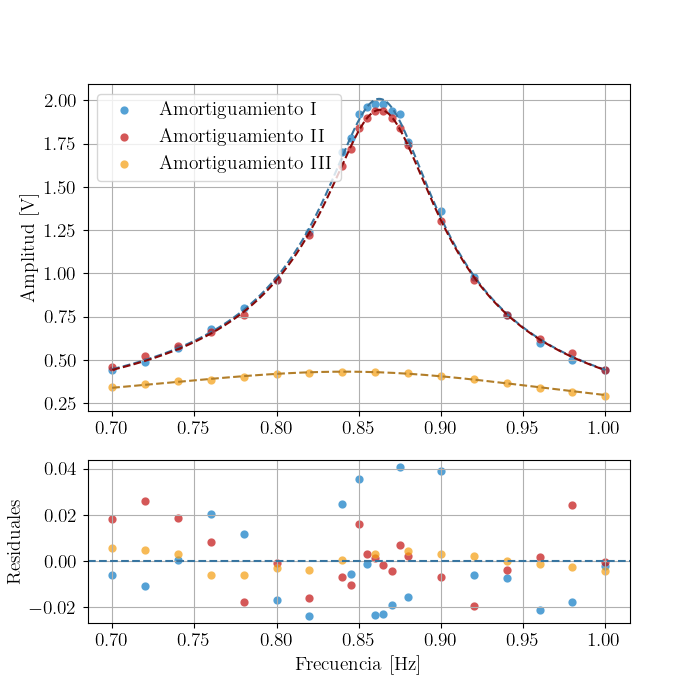

In [419]:
figure, axis = plt.subplots(2, 1, figsize = (7, 7), gridspec_kw={'height_ratios': [2, 1]})
axis[0].scatter(sfrequency, ssvoltage, color = "#0C79C4", edgecolors = "white", linewidths = 0.1, alpha = 0.7, label = "Amortiguamiento I")
axis[0].plot(_sfrequency_, Amplitude(_sfrequency_, *sfrequency_coeff), color = "#3875A0", linestyle = "--")
axis[0].set_ylabel("Amplitud [V]")
axis[0].grid(True)

axis[1].grid(True)
axis[1].scatter(sfrequency, sfrequency_residues, color = "#0C79C4", edgecolors = "white", linewidths = 0.1, alpha = 0.7)
axis[1].axhline(0, color = "#3875A0", linestyle = "--")
axis[1].set_ylabel("Residuales")
axis[1].set_xlabel("Frecuencia [Hz]")

axis[0].scatter(ffrequency,ffvoltage, color = "#C21010", edgecolors = "white", linewidths = 0.1, alpha = 0.7, label = "Amortiguamiento II")
axis[0].plot(_ffrequency_, Amplitude(_ffrequency_, *ffrequency_coeff), color = "#870808", linestyle = "--")
axis[0].grid(True)

axis[1].grid(True)
axis[1].scatter(ffrequency, ffrequency_residues, color = "#C21010", edgecolors = "white", linewidths = 0.1, alpha = 0.7)

axis[0].scatter(tfrequency, ttvoltage, color = "#F49D0E", edgecolors = "white", linewidths = 0.1, alpha = 0.7, label = "Amortiguamiento III")
axis[0].plot(_tfrequency_, Amplitude(_tfrequency_, *tfrequency_coeff), color = "#B27E29", linestyle = "--")
axis[0].grid(True)

axis[0].legend()

axis[1].grid(True)
axis[1].scatter(tfrequency, tfrequency_residues, color = "#F49D0E", edgecolors = "white", linewidths = 0.1, alpha = 0.7)

plt.savefig("Resonance.pdf")